This notebook requires version xxx of the `visual_behavior_glm` package

And version xxx of the `visual_behavior_analysis` package

And version 2.16.2 of the `AllenSDK``

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 1})

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
import visual_behavior.data_access.loading as loading
import visual_behavior.visualization.utils as utils
import visual_behavior.visualization.ophys.glm_example_plots as gep
import visual_behavior.dimensionatlity_reduction.clustering.processing as processing

In [13]:
from visual_behavior_glm.glm import GLM
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_across_session as gas

#### Set cache directory

In [15]:
# directory where files are loaded from or saved to
platform_cache_dir = loading.get_platform_analysis_cache_dir()
print(platform_cache_dir)

\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new


#### Load metadata tables

In [6]:
# Load metadata tables
all_experiments_table = pd.read_csv(os.path.join(platform_cache_dir, 'all_ophys_experiments_table.csv'), index_col=0)
platform_experiments = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_ophys_experiments_table.csv'), index_col=0)
platform_cells_table = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_ophys_cells_table.csv'), index_col=0)
matched_cells_table = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_matched_ophys_cells_table.csv'), index_col=0)


In [7]:
# confirm that filtered platform experiments and matched cells table have the same number of experiments
print(len(platform_cells_table.cell_specimen_id.unique()))
print(len(matched_cells_table.cell_specimen_id.unique()))

14495
3921


In [8]:
# confirm that filtered platform experiments and matched cells table have the same number of experiments
print(len(platform_experiments))
print(len(platform_cells_table.ophys_experiment_id.unique()))

402
402


#### Define model version

In [5]:
glm_version = '24_events_all_L2_optimize_by_session'


#### GLM results output files

Note this function requires access to internal Allen Institute servers

In [10]:
run_params, all_results, all_results_pivoted, all_weights_df = gfd.load_analysis_dfs(glm_version)

loading run_params
loading results df
loading results_pivoted df
loading weights_df


In [15]:
# rename experience level columns
all_results['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in all_results.experience_level.values]
all_results_pivoted['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in all_results_pivoted.experience_level.values]
all_weights_df['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in all_weights_df.experience_level.values]

# check conversion
print(all_results.experience_level.unique())
print(all_results_pivoted.experience_level.unique())
print(all_weights_df.experience_level.unique())

['Familiar' 'Novel' 'Novel +']
['Familiar' 'Novel +' 'Novel']
['Familiar' 'Novel +' 'Novel']


In [16]:
print(len(all_results_pivoted.ophys_experiment_id.unique()),
      'experiments in all_results_pivoted')

print(len(all_results_pivoted.cell_specimen_id.unique()),
      'cells in original results_pivoted')

1248 experiments in all_results_pivoted
28806 cells in original results_pivoted


In [17]:
print(len(all_weights_df.ophys_experiment_id.unique()),
      'experiments in all_weights_df')

print(len(all_weights_df.cell_specimen_id.unique()),
      'cells in all_weights_df')

1248 experiments in all_weights_df
28806 cells in all_weights_df


`run_params` contains important parameters used when the GLM was run, including `kernels` which contains the time window for all time varying kernels

In [18]:
run_params['kernels'].keys()

dict_keys(['intercept', 'hits', 'misses', 'passive_change', 'omissions', 'running', 'pupil', 'licks', 'image0', 'image1', 'image2', 'image3', 'image4', 'image5', 'image6', 'image7'])

In [19]:
run_params['kernels']['omissions']

{'event': 'omissions',
 'type': 'discrete',
 'length': 3,
 'offset': 0,
 'num_weights': None,
 'dropout': True,
 'text': 'image was omitted'}

`all_results` contains the dropout scores for all features for all cells, with one row per cell per experiment per feature


In [20]:
all_results.head()

,dropout,absolute_change_from_full,avg_L2_regularization,variance_explained,variance_explained_full,avg_cv_var_test_full_comparison_raw,avg_cv_var_test_raw,avg_cv_var_test_sem,cell_L2_regularization,fraction_change_from_full,...,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,experience_level,passive,image_set,file_id,identifier
0,Full,0.000000,288.892269,0.017993,0.017993,0.017993,0.017993,0.002585,64.189744,0.000000,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206
1,all-images,-0.004065,NaN,0.013928,0.017993,0.017993,0.013928,0.003010,NaN,-0.225934,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206
2,all-omissions,-0.000218,NaN,0.017775,0.017993,0.017993,0.017775,0.002572,NaN,-0.012096,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206
3,behavioral,0.000756,NaN,0.018749,0.017993,0.017993,0.018749,0.002656,NaN,0.000000,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206
4,image0,-0.000128,NaN,0.017865,0.017993,0.017993,0.017865,0.002586,NaN,-0.007113,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206


`all_results_pivoted` contains the dropout scores for all features, with one row per cell per experiment

In [21]:
# the identifier column is the combination of the ophys_experiment_id and the cell_specimen_id
all_results_pivoted.head()

,identifier,Full,all-images,all-omissions,behavioral,hits,image0,image1,image2,image3,...,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,experience_level,passive,image_set,file_id
0,1000743008_1086668144,0.0,-0.662105,-0.125224,-0.082598,-0.157348,0.000000,0.000000,-0.706346,0.000000,...,999191979,VisualBehaviorTask1B,275,VISp,2020-01-16 18:49:41.000000,OPHYS_1_images_B,Familiar,False,B,1003077167
1,1000743008_1086668169,0.0,-0.779696,0.000000,0.000000,0.000000,0.000000,0.000000,-0.107628,-0.439043,...,999191979,VisualBehaviorTask1B,275,VISp,2020-01-16 18:49:41.000000,OPHYS_1_images_B,Familiar,False,B,1003077167
2,1000743008_1086668188,0.0,-0.673067,-0.262118,0.000000,-0.071827,-0.810044,0.000000,-0.597487,-0.624969,...,999191979,VisualBehaviorTask1B,275,VISp,2020-01-16 18:49:41.000000,OPHYS_1_images_B,Familiar,False,B,1003077167
3,1000743008_1086668228,0.0,-0.704217,-0.128225,-0.043748,-0.055019,-0.366457,-0.816904,-0.137280,-0.388425,...,999191979,VisualBehaviorTask1B,275,VISp,2020-01-16 18:49:41.000000,OPHYS_1_images_B,Familiar,False,B,1003077167
4,1000743008_1086668247,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,999191979,VisualBehaviorTask1B,275,VISp,2020-01-16 18:49:41.000000,OPHYS_1_images_B,Familiar,False,B,1003077167


In [22]:
all_results_pivoted.keys()

Index(['identifier', 'Full', 'all-images', 'all-omissions', 'behavioral',
       'hits', 'image0', 'image1', 'image2', 'image3', 'image4', 'image5',
       'image6', 'image7', 'intercept', 'licks', 'misses', 'omissions',
       'passive_change', 'pupil', 'running', 'single-all-images',
       'single-all-omissions', 'single-behavioral', 'single-hits',
       'single-image0', 'single-image1', 'single-image2', 'single-image3',
       'single-image4', 'single-image5', 'single-image6', 'single-image7',
       'single-licks', 'single-misses', 'single-omissions',
       'single-passive_change', 'single-pupil', 'single-running',
       'single-task', 'single-visual', 'task', 'visual',
       'variance_explained_full', 'cell_specimen_id', 'cell_roi_id',
       'glm_version', 'ophys_experiment_id', 'ophys_session_id',
       'equipment_name', 'full_genotype', 'mouse_id', 'reporter_line', 'sex',
       'age_in_days', 'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_t

<Axes: ylabel='Count'>

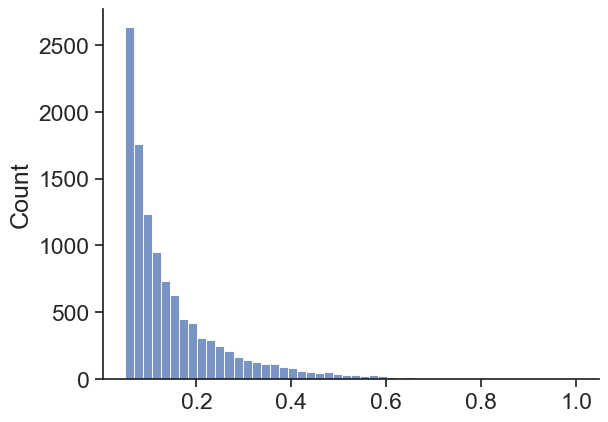

In [23]:
sns.histplot(all_results_pivoted.variance_explained_full.values, bins=50, binrange=(0.05, 1))

`all_weights_df` contains the kernel weights for all cells

In [24]:
all_weights_df.head()

,cell_specimen_id,ophys_experiment_id,intercept_weights,hits_weights,misses_weights,omissions_weights,running_weights,pupil_weights,licks_weights,image0_weights,...,image_set,file_id,all-images_weights,preferred_image_weights,task_weights,omissions_excited,hits_excited,misses_excited,task_excited,all-images_excited
0,1086668247,1000743008,[1.0056768709727721e-05],"[-1.2579108298572298e-05, -7.3000640740916605e...","[-7.755334509743032e-06, -4.091697266109858e-0...","[-3.3802521097003153e-06, -4.805559029255225e-...","[5.7473723863996325e-06, -1.3790754166744425e-...","[-1.474804109788128e-06, -7.031067732131923e-0...","[-6.433331120509854e-06, -6.966809423344184e-0...","[2.1527364846977593e-05, 5.695986301377951e-06...",...,B,1003077167,"[1.1155750590661174e-05, 1.8906445200468662e-0...","[5.0218254282183566e-05, 2.0435860604905756e-0...","[-1.0167221404157665e-05, -5.695880670100759e-...",False,False,False,False,True
1,1086668144,1000743008,[0.0005351101793638364],"[-3.825516432097155e-05, -2.4112010590356116e-...","[7.483326926076891e-06, 5.094201633904373e-06,...","[-0.0004951148325394667, -0.000506879559761089...","[-0.00015337360158769226, 0.000102279853356576...","[-0.0001087355575229075, 8.698133201227734e-06...","[6.144430072111849e-06, -7.219601568164387e-05...","[-0.0004957463746930891, -0.000502946576492789...",...,B,1003077167,"[-0.0005041422377356674, -0.000505604207996675...","[-0.0005040418217142819, -0.000499400592022079...","[-1.538591869744733e-05, -9.508904478225872e-0...",False,True,False,True,True
2,1086668169,1000743008,[0.0002622745678520738],"[3.7678071242673396e-05, 3.456077270913636e-05...","[-3.918164605445836e-06, -1.8894178428904233e-...","[-0.00024668316861037494, -0.00025340903969900...","[-4.3659491859739515e-07, -6.658711812377135e-...","[-4.942994173242607e-05, -1.7125012825857865e-...","[-9.124495979287886e-05, -8.531415610627177e-0...","[-0.0002528150810037059, -0.000251944456646128...",...,B,1003077167,"[-0.0002561057678755333, -0.000260326543598575...","[-0.00023718492713659502, -0.00025346981499829...","[1.687995331861378e-05, 1.718591546242366e-05,...",False,False,False,False,True
3,1086668188,1000743008,[0.00025492794872361123],"[-6.464322543117354e-05, -7.014323589821575e-0...","[6.494422291025291e-06, 6.524672132936487e-06,...","[-0.00022484485899115173, -0.00023457202810703...","[1.9781971680325244e-05, 2.1116470627896455e-0...","[-5.753202410962318e-05, -5.552098693934355e-0...","[-2.0167463809161296e-05, 1.5115439976289458e-...","[-0.0002507207223355315, -0.000252323168430528...",...,B,1003077167,"[-0.0002407820049676278, -0.000240960507261213...","[-0.00023795334204254484, -0.00025182500192987...","[-2.9074401570074122e-05, -3.180928188263963e-...",False,False,False,False,True
4,1086668228,1000743008,[0.0004730549871788817],"[-1.1730279358451463e-05, -1.8443214510054582e...","[-2.7925669145761954e-05, -2.6014517128872478e...","[-0.00041901841860166565, -0.00043262553606384...","[-5.086922026717127e-05, 2.7439379731477537e-0...","[-9.238775502496099e-05, 2.5090261215814243e-0...","[-4.046427643530497e-05, -7.554143014510062e-0...","[-0.00043740523611911133, -0.00044384457576967...",...,B,1003077167,"[-0.00040489673672985883, -0.00040478826993527...","[-0.0004178142215233247, -0.000423582668190753...","[-1.9827974252106708e-05, -2.222886581946353e-...",False,True,True,True,True


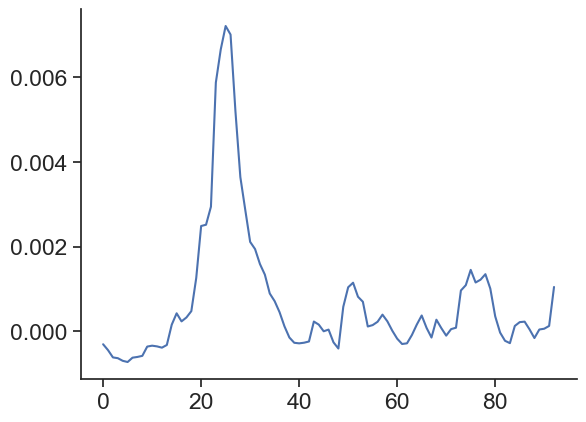

In [25]:
# plot omissions weights for one Vip cell
omissions_weights = all_weights_df[all_weights_df.cre_line=='Vip-IRES-Cre'].omissions_weights.values[0]
plt.plot(omissions_weights)

#### Across session normalized dropout scores

For use in clustering of cells matched across sessions

In [6]:
import visual_behavior_glm.GLM_across_session as gas


# get across session normalized dropout scores
across_results, failed_cells = gas.load_cells(glm_version, clean_df=True)
across_results = across_results.set_index('identifier')

# only use across session values
across = across_results[[key for key in across_results.keys() if '_across' in key] + ['cell_specimen_id', 'ophys_experiment_id', 'experience_level']]
across_results_pivoted = across.copy()
# rename across session columns 
across_results_pivoted = across_results_pivoted.rename(
    columns={'omissions_across': 'omissions', 'all-images_across': 'all-images',
             'behavioral_across': 'behavioral', 'task_across': 'task'})
print(len(across_results_pivoted), 'len(across_results_pivoted)')

# drop duplicates
across_results_pivoted = across_results_pivoted.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])
print(len(across_results_pivoted), 'len(across_results_pivoted) after dropping duplicates')
        
print(len(across_results_pivoted.cell_specimen_id.unique()),
      'cells in across_results_pivoted after limiting to strictly matched cells')

# limit to features used for clustering
# features = processing.get_features_for_clustering()
features = ['all-images', 'omissions', 'task', 'behavioral']
features = [*features, 'ophys_experiment_id']
across_results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(across_results_pivoted, features)

# flip sign so coding scores are positive
across_results_pivoted = processing.flip_sign_of_dropouts(across_results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

across_results_pivoted['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in across_results_pivoted.experience_level.values]

# SAVE
across_results_pivoted['cell_specimen_id'] = across_results_pivoted.cell_specimen_id.astype(int) # need to do this to save
# across_results_pivoted.to_hdf(os.path.join(platform_cache_dir, 'glm_results', 'across_session_normalized_platform_results_pivoted.h5'), key='df')

Loading list of matched cells


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the

removing 1 problematic experiments
Loading across session normalized dropout scores


100%|██████████| 3921/3921 [03:26<00:00, 18.96it/s]


0 cells could not be loaded


In [ ]:
across_results_pivoted.head()

,omissions_within,all-images_within,behavioral_within,task_within,omissions_across,all-images_across,behavioral_across,task_across,cell_roi_id,ophys_experiment_id,...,layer,area_layer,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure
identifier,,,,,,,,,,,,,,,,,,,,,
794381992_1086551315,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1080920847,794381992,...,lower,VISp_lower,20181212,False,-1.0,True,True,False,False,Familiar 3
795076128_1086551315,0.0,-0.660397,0.0,-0.131400,0.0,-0.295018,0.0,-0.094833,1080920879,795076128,...,lower,VISp_lower,20181213,True,0.0,False,False,False,False,Novel 0
796105304_1086551315,0.0,-0.258126,0.0,-0.430496,0.0,-0.258126,0.0,-0.430496,1080917349,796105304,...,lower,VISp_lower,20181215,False,2.0,False,False,False,True,Novel 2
794381992_1086550804,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1080920606,794381992,...,lower,VISp_lower,20181212,False,-1.0,True,True,False,False,Familiar 3
795076128_1086550804,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1080920638,795076128,...,lower,VISp_lower,20181213,True,0.0,False,False,False,False,Novel 0


In [8]:
print(len(across_results_pivoted.ophys_experiment_id.unique()))
print(len(across_results_pivoted.cell_specimen_id.unique()))

393
3921


In [28]:
for column in across_results_pivoted.columns: 
    if across_results_pivoted[column].dtype == 'Int64': 
        across_results_pivoted[column].astype('int')
    

omissions_within                               float64
all-images_within                              float64
behavioral_within                              float64
task_within                                    float64
omissions_across                               float64
all-images_across                              float64
behavioral_across                              float64
task_across                                    float64
cell_roi_id                                      int64
ophys_experiment_id                              int64
cell_specimen_id                                 int32
behavior_session_id                              int64
ophys_session_id                                 int32
ophys_container_id                               int64
mouse_id                                        object
indicator                                       object
full_genotype                                   object
driver_line                                     object
cre_line  

In [26]:
across_session_results.age_in_days = across_session_results.age_in_days.astype('int')
across_session_results.ophys_session_id = across_session_results.ophys_session_id.astype('int')
across_session_results.cell_specimen_id = across_session_results.cell_specimen_id.astype('int')


In [30]:
across_session_results.targeted_structure = across_session_results.targeted_structure.astype('str')       
across_session_results.second_novel_active = across_session_results.second_novel_active.astype('bool')                             
across_session_results.targeted_structure = across_session_results.targeted_structure.astype('str')                             
across_session_results.targeted_structure = across_session_results.targeted_structure.astype('str')                                                   

identifier
794381992_1086551315     VISp
795076128_1086551315     VISp
796105304_1086551315     VISp
794381992_1086550804     VISp
795076128_1086550804     VISp
                         ... 
1086910729_1120111711    VISl
1087825608_1120111711    VISl
1086707480_1120111106    VISl
1086910729_1120111106    VISl
1087825608_1120111106    VISl
Name: targeted_structure, Length: 11763, dtype: object

In [27]:
# across session results
across_session_results.to_hdf(os.path.join(platform_cache_dir, 'glm_results', 'across_session_normalized_results_pivoted.h5'), key='df')

TypeError: objects of type ``IntegerArray`` are not supported in this context, sorry; supported objects are: NumPy array, record or scalar; homogeneous list or tuple, integer, float, complex or bytes

#### Compare across session normalized results with original results

what changes?

#### Filter results files to limit to experiments used in paper analysis

In [26]:
platform_results_pivoted = all_results_pivoted.copy()

# limit to platform expts
platform_results_pivoted = platform_results_pivoted[platform_results_pivoted.ophys_experiment_id.isin(platform_experiments.index.values)]
 
print(len(platform_results_pivoted.ophys_experiment_id.unique()),
      'experiments in results_pivoted after limiting to platform experiments')

print(len(platform_results_pivoted.cell_specimen_id.unique()),
      'cells in results_pivoted after limiting to platform experiments')


402 experiments in results_pivoted after limiting to platform experiments
14495 cells in results_pivoted after limiting to platform experiments


In [27]:
platform_weights_df = all_weights_df.copy()

# limit to matched cells 
platform_weights_df = platform_weights_df[platform_weights_df.ophys_experiment_id.isin(platform_experiments.index.values)]
 
print(len(platform_weights_df.ophys_experiment_id.unique()),
      'experiments in weights_df after limiting to platform experiments')

print(len(platform_weights_df.cell_specimen_id.unique()),
      'cells in weights_df after limiting to platform experiments')


402 experiments in weights_df after limiting to platform experiments
14495 cells in weights_df after limiting to platform experiments


#### Save filtered GLM output files to cache

In [28]:
# results with full set of experiments
pd.to_pickle(run_params, os.path.join(platform_cache_dir, 'glm_results', glm_version+'_run_params.pkl'))
all_weights_df.to_hdf(os.path.join(platform_cache_dir, 'glm_results', 'all_weights_df.h5'), key='df')
all_results.to_hdf(os.path.join(platform_cache_dir, 'glm_results', 'all_results.h5'), key='df')
all_results_pivoted.to_hdf(os.path.join(platform_cache_dir, 'glm_results', 'all_results_pivoted.h5'), key='df')

# filtered results
platform_results_pivoted.to_hdf(os.path.join(platform_cache_dir, 'glm_results', 'platform_results_pivoted.h5'), key='df')
platform_weights_df.to_hdf(os.path.join(platform_cache_dir, 'glm_results', 'platform_weights_df.h5'), key='df')

# across session results
across_session_results.to_hdf(os.path.join(platform_cache_dir, 'glm_results', 'across_session_normalized_results_pivoted.h5'), key='df')

C:\Users\marinag\AppData\Local\Temp\ipykernel_29408\1239856578.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['intercept_weights', 'hits_weights', 'misses_weights',
       'omissions_weights', 'running_weights', 'pupil_weights',
       'licks_weights', 'image0_weights', 'image1_weights', 'image2_weights',
       'image3_weights', 'image4_weights', 'image5_weights', 'image6_weights',
       'image7_weights', 'passive_change_weights', 'identifier', 'glm_version',
       'equipment_name', 'full_genotype', 'reporter_line', 'sex', 'cre_line',
       'indicator', 'project_code', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'experience_level', 'image_set',
       'all-images_weights', 'preferred_image_weights', 'task_weights',
       'omissions_excited', 'hits_excited', 'misses_excited', 'task_excited',
       'all-images_excited']

### GLM model fits

Note that loading GLM model fits requires access to an internal Allen Institute mongo database

In [24]:
# check connection
import visual_behavior.database as db
conn = db.Database('visual_behavior_data')

conn.client

MongoClient(host=['behavioral-dynamics.corp.alleninstitute.org:27017'], document_class=dict, tz_aware=False, connect=True)

#### Load GLM object for one experiment

In [25]:
ophys_experiment_id = platform_experiments[platform_experiments.cre_line=='Sst-IRES-Cre'].index.values[10]
print(ophys_experiment_id)

993344860


In [26]:
glm = GLM(ophys_experiment_id, glm_version, log_results=False, log_weights=False, use_previous_fit=True, 
                recompute=False, use_inputs=False, inputs=None, NO_DROPOUTS=False, TESTING=False)

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\database.py:728: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


using repo version of GLM_fit_tools rather than the copy in frozen_model_files to deal with SDK updates
loading previous fit...
loading fit
//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_24_events_all_L2_optimize_by_session/experiment_model_files\993344860.pbz2
file exists True
fit loaded
loading sdk object


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


    Adding kernel: intercept
    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: passive_change
	Error encountered while adding kernel for passive_change. Attemping to continue without this kernel.
	Passive Change kernel cant be added to active sessions
    Adding kernel: omissions
    Adding kernel: running
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: pupil
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: licks
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
The following kernels failed to be added to the model: 
{'passive_change'}

The following dropouts failed to be added to the model: 
{'single-passive_change'}

Checked weight/kernel lengths against timesteps per stimulus
done loading previous fit
do

C:\Users\marinag\Documents\Code\visual_behavior_glm\visual_behavior_glm\GLM_fit_tools.py:804: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results[model_label+"__avg_cv_var_test"]  = np.nanmean(temp,1)
C:\Users\marinag\Documents\Code\visual_behavior_glm\visual_behavior_glm\GLM_fit_tools.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results[model_label+"__avg_cv_var_test_sem"] = np.std(temp,1)/np.sqrt(np.shape(temp)[1])
C:\Users\marinag\Documents\Code\visual_behavior_glm\visual_behavior_glm\GLM_fit_tools.py:810: Performa

done collecting results
done building GLM object


The `GLM` object contains several useful attributes, including the `cell_results_df` which contains model fits for all cells in the experiment, and a full table of model `results`, and a `dropout_summary`. 

The `results` and `dropout_summary` contain roughly the same information as the `all_results` and `all_results_pivoted` tables loaded above, except limited to the specific experiment loaded via the `GLM` object. 

The important part here is the `cell_results_df` which contains the model fits. 

In [27]:
glm.results.keys()

Index(['Full__avg_cv_var_train', 'Full__avg_cv_var_train_raw',
       'Full__avg_cv_var_test_raw',
       'Full__avg_cv_var_test_full_comparison_raw', 'Full__avg_cv_var_test',
       'Full__avg_cv_var_test_sem', 'Full__avg_cv_var_test_full_comparison',
       'Full__avg_cv_adjvar_train', 'Full__avg_cv_adjvar_test_raw',
       'Full__avg_cv_adjvar_test_full_comparison_raw',
       ...
       'single-all-omissions__avg_cv_adjvar_test_full_comparison',
       'single-all-omissions__absolute_change_from_full',
       'single-all-omissions__dropout', 'single-all-omissions__adj_dropout',
       'single-all-omissions__adj_dropout_raw', 'Full__shuffle_cells',
       'Full__shuffle_time', 'Full__avg_L2_regularization',
       'Full__cell_L2_regularization', 'cell_roi_id'],
      dtype='object', length=645)

In [28]:
glm.dropout_summary.head()

,dropout,absolute_change_from_full,avg_L2_regularization,variance_explained,variance_explained_full,avg_cv_var_test_full_comparison_raw,avg_cv_var_test_raw,avg_cv_var_test_sem,avg_cv_var_train_raw,cell_L2_regularization,...,shuffle_cells,shuffle_time,cell_specimen_id,adj_fraction_change_from_full,adj_dropout_raw,adj_variance_explained,adj_variance_explained_full,avg_cv_adjvar_test_full_comparison_raw,avg_cv_adjvar_test_raw,cell_roi_id
0,Full,0.000000,206.102747,0.006958,0.006958,0.000000,0.0,0.002030,0.018381,500.0,...,-0.005458,-0.011164,1086491368,0.000000,0.0,0.006958,0.006958,0.0,0.0,1080708164
1,all-images,-0.005874,NaN,0.001084,0.006958,0.006958,0.0,0.000505,0.009627,NaN,...,NaN,NaN,1086491368,-0.826629,0.0,0.001230,0.007092,0.0,0.0,1080708164
2,all-omissions,0.000015,NaN,0.006973,0.006958,0.006958,0.0,0.002035,0.017507,NaN,...,NaN,NaN,1086491368,0.000000,0.0,0.000000,0.000000,0.0,0.0,1080708164
3,behavioral,0.000744,NaN,0.007701,0.006958,0.006958,0.0,0.002131,0.013010,NaN,...,NaN,NaN,1086491368,0.000000,0.0,0.007701,0.006958,0.0,0.0,1080708164
4,hits,-0.000691,NaN,0.006267,0.006958,0.006958,0.0,0.001992,0.016602,NaN,...,NaN,NaN,1086491368,-0.285793,0.0,0.010180,0.014254,0.0,0.0,1080708164


In [29]:
glm.cell_results_df.head()

,index,fit_trace_timestamps,cell_specimen_id,fit_array,dff,events,model_prediction,frame_index
0,0,306.02914,1086491368,0.0,0.029295,0.0,-0.000085,9383
1,1,306.02914,1086490689,0.0,0.087772,0.0,-0.000201,9383
2,2,306.02914,1086490391,0.0,0.044929,0.0,0.000215,9383
3,3,306.02914,1086490526,0.0,0.029682,0.0,-0.001013,9383
4,4,306.02914,1086490482,0.0,0.017572,0.0,0.000076,9383


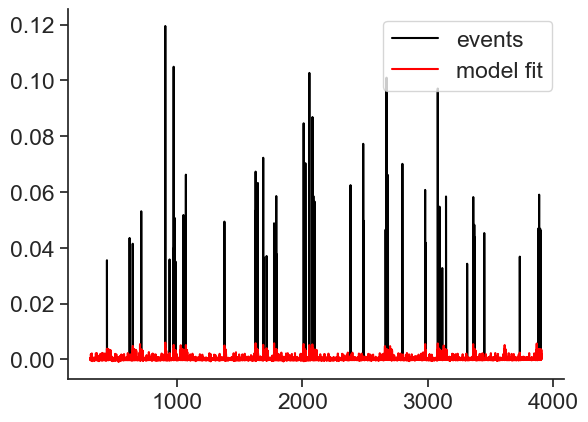

In [30]:
# plot the model fit and original trace for one cell
cell_results_df = glm.cell_results_df.copy()
cell_specimen_id = cell_results_df.cell_specimen_id.unique()[10]
this_cell_results = cell_results_df[cell_results_df.cell_specimen_id==cell_specimen_id]

plt.plot(this_cell_results.fit_trace_timestamps, this_cell_results.events, label='events', color='k')
plt.plot(this_cell_results.fit_trace_timestamps, this_cell_results.model_prediction, label='model fit', color='r')
# plt.xlim(3800, 3900)
plt.legend()


#### Load model fits using VBA function

This function will check whether the relevant files have already been saved to the platform_analysis_cache_dir, and if not, it will generate and save them

In [31]:
cell_results_df = gep.get_glm_model_fit_cell_results_df(ophys_experiment_id)

filepath at \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\glm_results\model_fits\993344860_cell_results_df.h5
file exists, loading


In [32]:
cell_results_df.head()

,index,fit_trace_timestamps,cell_specimen_id,fit_array,dff,events,model_prediction,frame_index
0,0,306.02914,1086491368,0.0,0.029295,0.0,-0.000085,9383
1,1,306.02914,1086490689,0.0,0.087772,0.0,-0.000201,9383
2,2,306.02914,1086490391,0.0,0.044929,0.0,0.000215,9383
3,3,306.02914,1086490526,0.0,0.029682,0.0,-0.001013,9383
4,4,306.02914,1086490482,0.0,0.017572,0.0,0.000076,9383


#### Generate and save GLM model fit files for all experiments

In [33]:
# # all experiments
# ophys_experiment_ids = all_experiments_table.index.values
# only platform experiments
# ophys_experiment_ids = platform_experiments.index.values
# # all experiments other than platform experiments
# ophys_experiment_ids = all_experiments_table[all_experiments_table.ophys_experiment_id.isin(platform_experiments.index.values)==False]

# failed_expts = []
# for ophys_experiment_id in ophys_experiment_ids:
#     print('***', np.where(ophys_experiment_ids==ophys_experiment_id)[0][0], 'out of', len(ophys_experiment_ids), '*****')
#     try:
#         cell_results_df = gep.get_glm_model_fit_cell_results_df(ophys_experiment_id)
#     except: 
#         print('failed for ', ophys_experiment_id)
#         failed_expts.append(ophys_experiment_id)

#### aggregate GLM model fit results across experiments 

In [ ]:
all_expt_results = pd.DataFrame()
ophys_experiment_ids = all_experiments_table.index.values
for ophys_experiment_id in ophys_experiment_ids:
    print(np.where(ophys_experiment_ids==ophys_experiment_id)[0][0], 'out of', len(ophys_experiment_ids))

    cell_results_df, expt_results, dropouts = gep.load_glm_model_fit_results(ophys_experiment_id)
    expt_results['ophys_experiment_id'] = ophys_experiment_id
    all_expt_results = pd.concat([all_expt_results, expt_results])

all_expt_results.to_hdf(os.path.join(platform_cache_dir, 'glm_results', 'all_glm_results_for_experiments.h5'), key='df')